In [ ]:
import math, random, os, nbformat
from nbformat.v4 import new_notebook, new_code_cell, new_markdown_cell
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
def create_nodes(n, field=(100,100), energy=1.0, seed=1):
    random.seed(seed); np.random.seed(seed)
    return [{"id":i, "x":random.uniform(0,field[0]), "y":random.uniform(0,field[1]), "e":energy, "alive":True} for i in range(n)]


def dist(a,b): return math.hypot(a["x"]-b[0], a["y"]-b[1])

In [ ]:
# simple radio params
E_ELEC=50e-9; E_FS=1e-11; E_MP=1.3e-15; D0=math.sqrt(E_FS/E_MP)
def tx_cost(bits,d):
    amp = E_FS if d<D0 else E_MP
    return E_ELEC*bits + amp*bits*(d**(2 if d<D0 else 4))
def rx_cost(bits): return E_ELEC*bits

In [ ]:
def run(nodes, sink, rounds=200, mode="direct", p_ch=0.05, packet=4000):
    rows=[]
    for r in range(1, rounds+1):
        energy_used=0; packets=0
        alive_nodes=[n for n in nodes if n["alive"]]
        if not alive_nodes:
            break
        if mode=="direct":
            for n in alive_nodes:
                c=tx_cost(packet, dist(n, sink))
                if n["e"]>=c:
                    n["e"]-=c; energy_used+=c; packets+=1
                else:
                    n["e"]=0; n["alive"]=False
        else: # cluster
            chs=[n for n in alive_nodes if random.random()<p_ch]
            if not chs: # fallback direct
                for n in alive_nodes:
                    c=tx_cost(packet, dist(n, sink))
                    if n["e"]>=c:
                        n["e"]-=c; energy_used+=c; packets+=1
                    else:
                        n["e"]=0; n["alive"]=False
            else:
                # non-CH -> nearest CH
                member_map={ch["id"]:[] for ch in chs}
                for n in alive_nodes:
                    if n in chs: continue
                    # nearest ch
                    nearest=min(chs, key=lambda ch: math.hypot(n["x"]-ch["x"], n["y"]-ch["y"]))
                    d=math.hypot(n["x"]-nearest["x"], n["y"]-nearest["y"])
                    c=tx_cost(packet,d)
                    if n["e"]>=c:
                        n["e"]-=c; energy_used+=c; packets+=1
                        member_map[nearest["id"]].append(n)
                    else:
                        n["e"]=0; n["alive"]=False
                # CHs receive & send
                for ch in chs:
                    members=member_map[ch["id"]]
                    recv = sum(rx_cost(packet) for _ in members)
                    agg = 5e-9*packet if members else 0
                    tx = tx_cost(packet, dist(ch, sink))
                    total = recv + agg + tx
                    if ch["e"]>=total:
                        ch["e"]-=total; energy_used+=total; packets+=1+len(members)
                    else:
                        ch["e"]=0; ch["alive"]=False
        rows.append({"round":r, "energy_left":sum(n["e"] for n in nodes), "alive":sum(1 for n in nodes if n["alive"]), "packets":packets})
    return pd.DataFrame(rows)

In [ ]:
# parameters
NUM_NODES=60; ROUNDS=200; INIT_ENERGY=1.0; SINK=(50,120); PACKET=4000
nodes1=create_nodes(NUM_NODES, energy=INIT_ENERGY, seed=2)
nodes2=[dict(n) for n in nodes1]  # shallow copy of positions; energy will be independent
df_direct = run(nodes1, SINK, rounds=ROUNDS, mode="direct", packet=PACKET)
df_cluster = run(nodes2, SINK, rounds=ROUNDS, mode="cluster", p_ch=0.06, packet=PACKET)

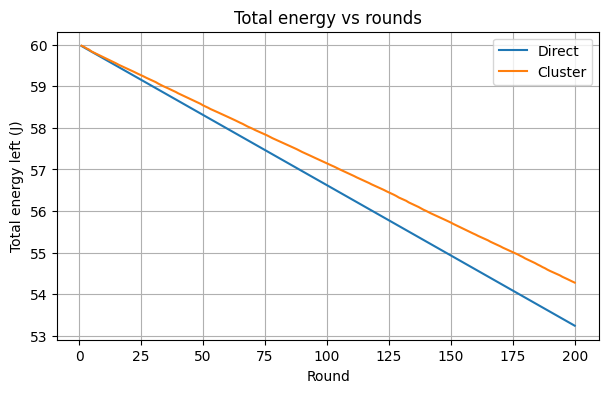

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(df_direct["round"], df_direct["energy_left"], label="Direct")
plt.plot(df_cluster["round"], df_cluster["energy_left"], label="Cluster")
plt.xlabel("Round"); plt.ylabel("Total energy left (J)"); plt.title("Total energy vs rounds"); plt.legend(); plt.grid(True)
plt.show()

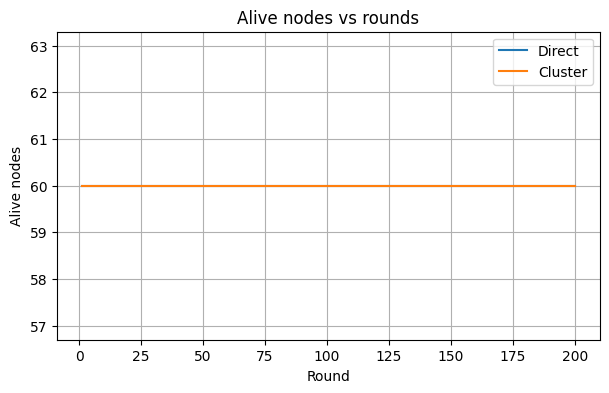

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(df_direct["round"], df_direct["alive"], label="Direct")
plt.plot(df_cluster["round"], df_cluster["alive"], label="Cluster")
plt.xlabel("Round"); plt.ylabel("Alive nodes"); plt.title("Alive nodes vs rounds"); plt.legend(); plt.grid(True)
plt.show()

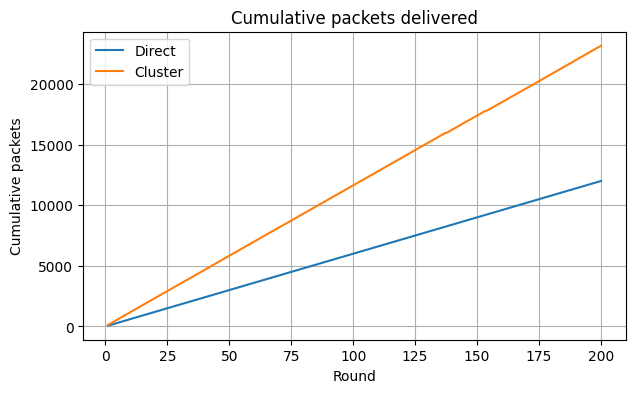

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(df_direct["round"], df_direct["packets"].cumsum(), label="Direct")
plt.plot(df_cluster["round"], df_cluster["packets"].cumsum(), label="Cluster")
plt.xlabel("Round"); plt.ylabel("Cumulative packets"); plt.title("Cumulative packets delivered"); plt.legend(); plt.grid(True)
plt.show()